In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ripple_detection import Karlsson_ripple_detector, Kay_ripple_detector

# Load LFP data

In [3]:
# #------------------------------------------------------------------------------
# # load data from S1 data file 
# #------------------------------------------------------------------------------
import pickle
from matplotlib import pyplot as plt
import os
import IPython as ipy
import pickle as pkl
import scipy.signal as ss
import scipy.io as sio
import numpy as np
import mat73

from scipy.signal import butter, lfilter
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

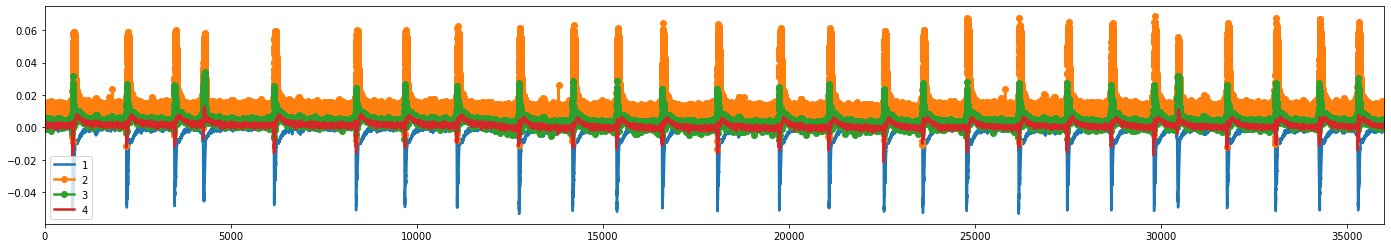

In [4]:
V = {}
for el in range(4):
    V[el] = []

dirname = '/home/fernando/Dropbox/SUNY/2023/v106/'


for vname in ['v106_batch1']:    
    
    for bseed in [0, 1, 4]:     
        
        with open(dirname+vname+'/'+vname+'_'+str(bseed)+'_data.pkl', 'rb') as fileObj: S1Data = pickle.load(fileObj)    

        for t in range(6000-1,30000-1):
            for el in range(4):
                if abs(S1Data['simData']['LFP'][t][el]) < 0.00001:
                    xt = (S1Data['simData']['LFP'][t-1][el]+S1Data['simData']['LFP'][t+1][el])/2.0
                    V[el].append(xt)   
                else:
                    V[el].append(S1Data['simData']['LFP'][t][el])   


            
            
            
timeRange = [0, 36000]
recordStep = 0.5
t = np.arange(timeRange[0], timeRange[1], recordStep) 

plt.figure(figsize=(24,4))
fontSize = 12
lw = 1

plt.plot(t,V[0], '-', linewidth=2.5, label='1')
plt.plot(t,V[1], '-o', linewidth=2.5, label='2')
plt.plot(t,V[2], '-o', linewidth=2.5, label='3')
plt.plot(t,V[3], '-', linewidth=2.5, label='4')
plt.xlim(0,36000);
# plt.xlim(1500,2500);
plt.legend();

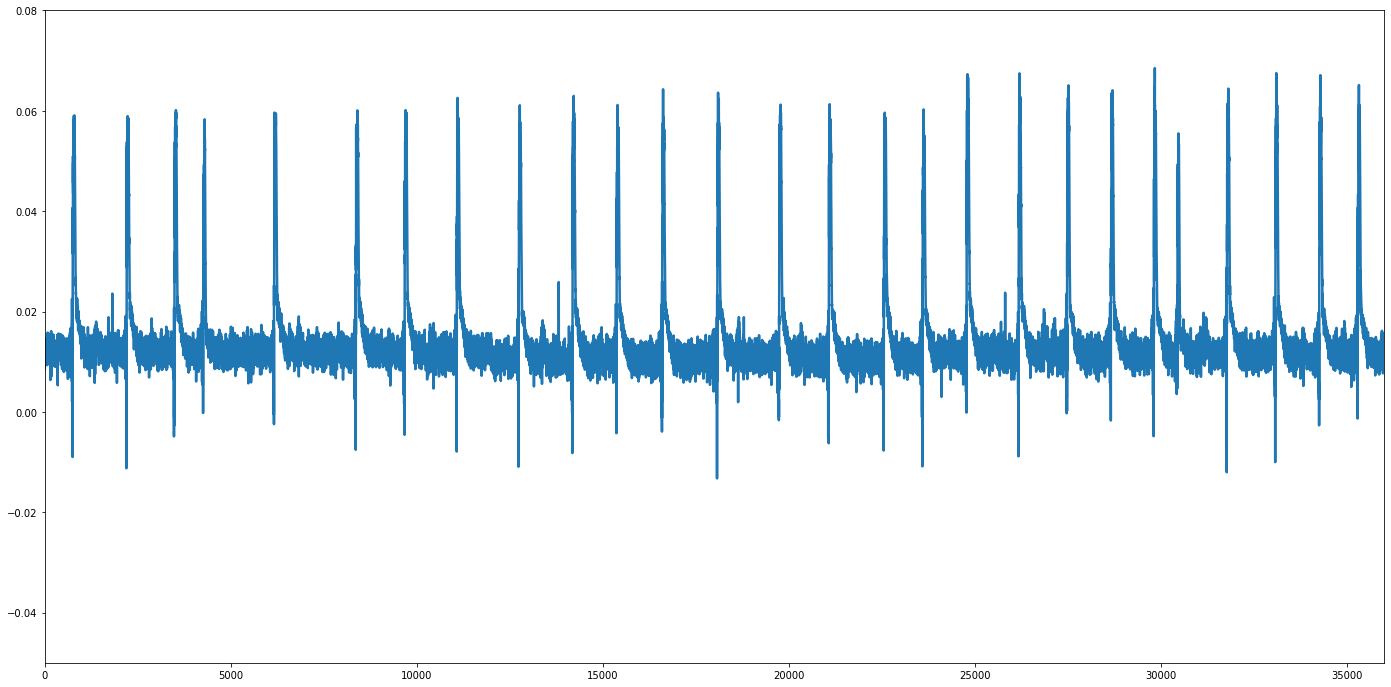

In [5]:
plt.figure(figsize=(24,12))
fontSize = 12
lw = 1

# plt.subplot(4,1,1)
# plt.plot(t,V[0], '-', linewidth=2.5, label='1')
# plt.xlim(0,300000);
# plt.ylim(-0.06,0.1);
# plt.legend();
# plt.subplot(4,1,2)
plt.plot(t,V[1], '-', linewidth=2.5, label='2')
plt.xlim(0,36000);
plt.ylim(-0.05,0.08);
# plt.legend();
# plt.subplot(4,1,3)
# plt.plot(t,V[2], '-', linewidth=2.5, label='3')
# plt.xlim(0,300000);
# plt.ylim(-0.06,0.1);
# plt.legend();
# plt.subplot(4,1,4)
# plt.plot(t,V[3], '-', linewidth=2.5, label='4')
# plt.xlim(0,300000);
# plt.ylim(-0.06,0.1);
# plt.legend();

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def notch_filter(samp_freq,notch_freq,quality_factor,time,x):
    # Set time vector
    n = time
    noisySignal = x    
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
    freq, h = signal.freqz(b_notch, a_notch, fs=samp_freq)    
    # Apply notch filter to the noisy signal using signal.filtfilt
    outputSignal = signal.filtfilt(b_notch, a_notch, noisySignal)    
    return outputSignal

In [7]:
lfps = []
fs = 2000.0
lowcut = 20.0
highcut = 500.0

for mat_fnumber in range(4):
        
    y2 = butter_bandpass_filter(V[mat_fnumber], lowcut, highcut, fs, order=5)
    
    lfps.append(y2)

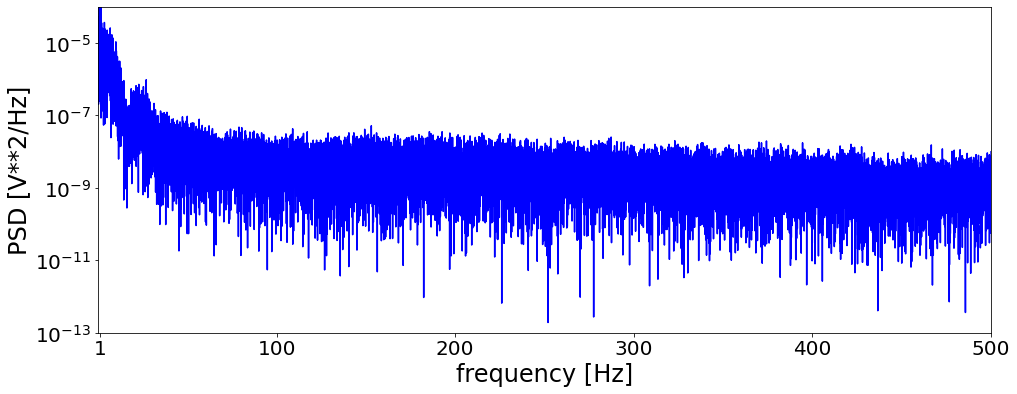

In [8]:
plt.figure(figsize=(16,6))
fontSize = 12

f, Pxx_den = ss.periodogram(V[1], fs)
plt.semilogy(f, Pxx_den,'b')

# f, Pxx_den = ss.periodogram(V[2], fs)
# plt.semilogy(f, Pxx_den,'r')

plt.ylim([1e-13, 1e-4])
plt.xlim([0.1, 500])
plt.xlabel('frequency [Hz]', fontsize=24)
plt.ylabel('PSD [V**2/Hz]', fontsize=24)
plt.yticks(fontsize = 20)
plt.xticks([1,100,200, 300,400,500], fontsize=20);

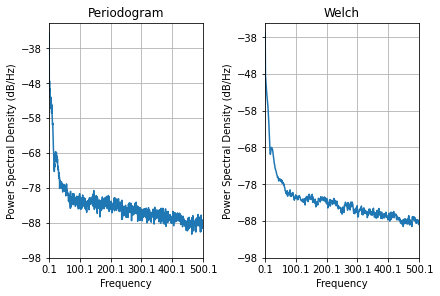

In [9]:
import matplotlib.mlab as mlab

fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True)
xticks = np.arange(0.1, 502, 100)
xrange = (xticks[0], xticks[-1])

ax0.psd(V[1], NFFT=4001, Fs=fs, window=mlab.window_none,
        scale_by_freq=True)
ax0.set_title('Periodogram')
ax0.set_xticks(xticks)
ax0.set_xlim(xrange)

ax1.psd(V[1], NFFT=2000, Fs=fs, window=mlab.window_none, noverlap=750,
        scale_by_freq=True)
ax1.set_title('Welch')
ax1.set_xticks(xticks)
ax1.set_xlim(xrange)

plt.show()

## Many LFPs, only two LFPs with ripples

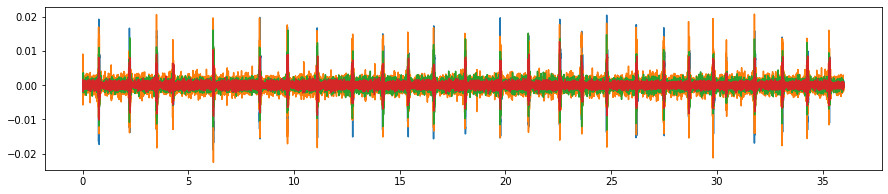

In [10]:
lfps2 = np.stack(
    (
        lfps[0],
        lfps[1],
        lfps[2],
        lfps[3],
#         lfps[4],
#         lfps[5],
#         lfps[6],
#         lfps[7],
    ),
    axis=1,
)


fs = 2000.0

time = np.linspace(0, np.size(V[0])/fs, np.size(V[0]))

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps2)
speed = np.ones_like(time)


In [11]:
from ripple_detection import filter_ripple_band

SAMPLING_FREQUENCY = fs

In [12]:
filtered_lfps = filter_ripple_band(lfps2)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

,start_time,end_time
ripple_number,,
1,0.674009,0.805511
2,2.124530,2.263531
3,3.438048,3.541049
4,4.187058,4.321060
5,6.129085,6.228087
6,8.294115,8.427617
7,9.617634,9.729635
8,11.032653,11.125655
9,14.132196,14.253198


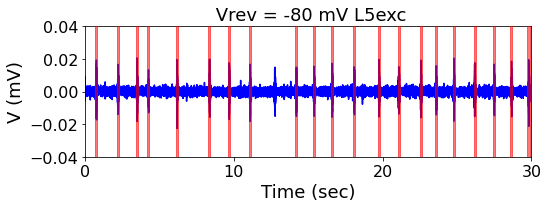

In [13]:
plt.figure(figsize=(8,2.4))

plt.title(' Vrev = -80 mV L5exc', fontsize=18)

for ripple in Karlsson_ripple_times.itertuples():
    plt.axvspan(ripple.start_time, ripple.end_time, alpha=0.53, color="red", zorder=1000)

plt.plot(time, lfps2,'b')
plt.xlim(0,30)
plt.ylim(-0.04,0.04);

plt.yticks([-0.04,-0.02, 0 , 0.02,0.04], fontsize=16)
plt.xticks([0, 10, 20, 30], fontsize=16)
plt.ylabel('V (mV)', fontsize=18)
plt.xlabel('Time (sec)', fontsize=18)

plt.savefig('LFP_26FRs_DeltaVrev_-70mV_L5exc.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

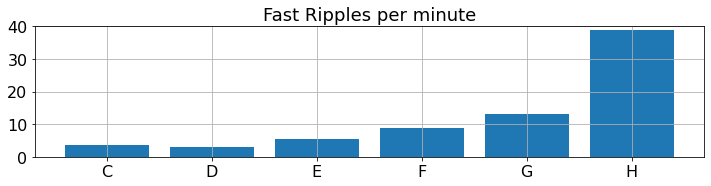

In [23]:
plt.figure(figsize=(12,2.4))

plt.title(r'Fast Ripples per minute', fontsize=18)

langs = ['C', 'D', 'E', 'F', 'G', 'H']
students = [18/5.0,15/5.0,27/5.0,44/5.0,66/5.0,195/5.0]
plt.bar(langs,students)
        
# plt.ylabel('FRs rate', fontsize=18)

plt.ylim(0.0,40.0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid(True)

plt.savefig('FR_rate.png', facecolor = 'white', bbox_inches='tight' , dpi=300)
